<a href="https://colab.research.google.com/github/FlyAIBox/Context-Engineering/blob/fly/10_guides_zero_to_hero/02_expand_context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 上下文扩展技巧：从提示到分层上下文

以实践为导向，演示如何将基础提示逐步演化为“分层、信息密度更高”的上下文结构，以提升大模型表现。重点在于：如何有策略地添加与组织上下文层，并系统化衡量它们对 token 开销与输出质量的影响。

- 由最小提示过渡到“信息丰富、结构清晰”的上下文
- 上下文分层与“组合式提示工程”的原则
- 随上下文增长对 token 使用与质量的测量与可视化
- 压缩与修剪：控制成本的关键技巧
- RAG：结合检索的上下文扩展

**建议：** 逐格运行每个单元，改动提示与参数，观察对输出与指标的影响。

**核心功能和目的可以概括为：**

- **演示不同层次的上下文构建：** 从基础提示逐步增加角色、示例、约束等信息，构建更丰富、信息密度更高的提示。
- **量化上下文的影响：** 通过测量不同提示的 Token 数量、模型响应时延和效率，来分析不同上下文策略的成本和效果。
- **探索上下文优化技巧：** 包括使用模型进行上下文压缩（总结、关键词、要点提取）和结合检索（RAG）增强提示。
- **提供实践框架：** 构建了一套 Python 函数和流程，方便用户在自己的任务中复用和测试不同的上下文策略。

总的来说，它的主要目的是帮助用户理解和掌握如何通过优化提示上下文来更好地利用大型语言模型。

### 0. 环境准备
含依赖，大模型

In [1]:
# Install necessary libraries
%pip install openai==1.61.0 matplotlib==3.10.0 tiktoken==0.11.0

In [2]:
# 大模型设置
import os
import time
from typing import Dict, List, Tuple, Any, Optional

# 导入 matplotlib 用于数据可视化，如果环境中没有则跳过
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    plt = None
    HAS_MPL = False

# OpenAI API 环境配置
# 设置默认使用的 OpenAI 模型
DEFAULT_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
# 获取 OpenAI API Key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY","sk-R2utGqjya03Bgnc77273729e7b73457e97A140D79bF3B944") # Added API Key variable
# 设置 OpenAI API 的基础 URL
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL","https://api.apiyi.com/v1") # Added Base URL variable


from openai import OpenAI
# 初始化 OpenAI 客户端，传入 API Key 和基础 URL
client: OpenAI = OpenAI(api_key=OPENAI_API_KEY, base_url=OPENAI_BASE_URL) # Added api_key and base_url


# tiktoken 可选库，用于更精确地计算 Token 数量
# 如果 tiktoken 没有安装，则退化为粗略的 Token 估计方法
try:
    import tiktoken
    # 根据模型获取 tiktoken 编码器
    tokenizer = tiktoken.encoding_for_model(DEFAULT_MODEL)
except Exception:
    # 如果 tiktoken 导入失败，设置 tokenizer 为 None
    tokenizer = None

# 计算给定文本的 Token 数量
def count_tokens(text: str) -> int:
    if tokenizer is not None:
        # 如果 tiktoken 可用，使用 tiktoken 精确计算
        return len(tokenizer.encode(text))
    # 如果 tiktoken 不可用，使用粗略的方法估计 Token 数量（按词数 * 1.3）
    return int(len(text.split()) * 1.3)

# 测量函数的执行时间
# def measure_latency(func, *args, **kwargs) -> Tuple[Any, float]:
#     t0 = time.time() # 记录开始时间
#     res = func(*args, **kwargs) # 执行函数
#     t1 = time.time() # 记录结束时间
#     return res, (t1 - t0) # 返回函数结果和执行时间

In [3]:
# 调用大模型生成响应
def generate_response(prompt: str) -> Tuple[str, float]:
    # 客户端已初始化
    try:
        t0 = time.time() # 记录调用开始时间
        # 调用 OpenAI Chat Completion API
        resp = client.chat.completions.create(
            model=DEFAULT_MODEL, # 指定使用的模型
            messages=[{"role": "user", "content": prompt}], # 传递用户提示
            temperature=0.7, # 设置生成的多样性（0.0-1.0，越高越随机）
            max_tokens=800, # 设置响应的最大 Token 数量
        )
        latency = time.time() - t0 # 计算调用时延
        # 返回生成的文本内容和时延
        return resp.choices[0].message.content or "", latency
    except Exception as e:
        # 如果调用失败，返回错误信息和 0 时延
        return f"[OpenAI 调用失败：{e}]", 0.0

# 计算与模型交互相关的指标
def calculate_metrics(prompt: str, response: str, latency: float) -> Dict[str, float]:
    pt = count_tokens(prompt) # 计算提示的 Token 数量
    rt = count_tokens(response) # 计算响应的 Token 数量

    # 计算 Token 效率（响应 Token / 提示 Token），提示 Token 为 0 时效率为 0
    eff = (rt / pt) if pt > 0 else 0.0

    # 计算每千 Token 的时延（时延 / 提示 Token * 1000），提示 Token 为 0 时时延为 0
    latency_per_1k = (latency / pt) * 1000 if pt > 0 else 0.0

    # 返回包含各种指标的字典
    return {
        "prompt_tokens": pt,
        "response_tokens": rt,
        "token_efficiency": eff,
        "latency": latency,
        # 将每千 Token 的时延（秒），并四舍五入到两位小数
        "latency_per_1k": round(latency_per_1k, 2), # Convert to ms and round
    }

### 1. 从最小提示到扩展提示

定义基础提示与多种扩展变体（角色、示例、约束、受众、综合）。


In [5]:
# 定义一个基础提示
base_prompt = "请写一段关于旅游路线规划的说明文字。"

# 创建不同类型的扩展提示，通过添加不同的上下文信息
expanded_prompts = {
    # 基础提示，不包含任何额外上下文
    "base": base_prompt,
    # 添加“角色”上下文：指定模型扮演的角色
    "with_role": "你是一名专业的旅游规划师。\n请写一段关于旅游路线规划的说明文字。",
    # 添加“示例”上下文：提供期望输出的例子（Few-shot learning）
    "with_examples": (
        "请写一段关于旅游路线规划的说明文字。\n\n"
        "示例 1：\n旅游路线规划是制定旅行行程的过程，包括选择目的地、交通方式、住宿、景点和活动等。一个好的规划能帮助旅行者充分利用时间，控制预算，并获得更好的旅行体验。\n\n"
        "示例 2：\n规划旅游路线时，需要考虑旅行时间、预算、旅行偏好（如文化、自然、探险）、同行人员以及当地的气候和季节。详细的规划可以包括每日行程、预订信息和备用方案。"
    ),
    # 添加“约束”上下文：指定输出需要满足的条件或规则
    "with_constraints": (
        "请写一段关于旅游路线规划的说明文字。\n"
        "- 至少包含三个关键考虑因素（如预算、时间、偏好）\n"
        "- 提及规划的好处\n"
        "- 以‘开始你的规划吧！’结尾\n"
        "- 保持实用且易于理解的语气"
    ),
    # 添加“受众”上下文：指定目标读者或用户
    "with_audience": (
        "请为第一次计划自由行的大学生，写一段关于旅游路线规划的说明文字，\n"
        "尽量使用简单易懂的语言和实用的建议。"
    ),
    # 综合提示：结合了多种上下文层，构建一个信息更全面的提示
    "comprehensive": (
        "你是一名专业的旅游规划师。\n\n" # 角色
        "请为第一次计划自由行的大学生，写一段关于旅游路线规划的说明文字，\n" # 基础任务与受众
        "使用简单易懂的语言和实用的建议。\n\n" # 受众相关要求
        "写作指南：\n" # 约束/指南
        "- 至少包含三个关键考虑因素（如预算、时间、偏好）\n"
        "- 提及规划的好处\n"
        "- 以‘开始你的规划吧！’结尾\n"
        "- 保持实用且易于理解的语气\n\n"
        "语气与结构示例：\n" # 示例（提供输出的风格和结构参考）
        "计划一次旅行就像是画一张寻宝图，每一步都很重要。首先，定好你的目的地和大概的旅行日期。然后，考虑你的预算，这会影响你的交通和住宿选择。别忘了你的兴趣，是喜欢自然风光还是城市探索？"
    ),
}

In [6]:
# 用于存储不同提示的测试结果
results = {}
# 用于存储不同提示生成的响应
responses = {}

# 遍历每种扩展提示进行测试
for name, p in expanded_prompts.items():
    print(f"测试：{name}")
    # 调用生成响应函数，并测量时延
    resp, lat = generate_response(p)
    # 存储生成的响应
    responses[name] = resp
    # 计算并存储各种指标（Token 数、效率、时延等）
    results[name] = calculate_metrics(p, resp, lat)
    # 打印测试结果摘要
    print("  提示 token：", results[name]["prompt_tokens"])
    print("  响应 token：", results[name]["response_tokens"])
    print("  时延：{:.2f}s".format(results[name]["latency"]))
    print("-" * 40)

测试：base
  提示 token： 12
  响应 token： 256
  时延：2.87s
----------------------------------------
测试：with_role
  提示 token： 21
  响应 token： 228
  时延：2.79s
----------------------------------------
测试：with_examples
  提示 token： 118
  响应 token： 276
  时延：10.10s
----------------------------------------
测试：with_constraints
  提示 token： 62
  响应 token： 215
  时延：5.76s
----------------------------------------
测试：with_audience
  提示 token： 35
  响应 token： 347
  时延：3.99s
----------------------------------------
测试：comprehensive
  提示 token： 164
  响应 token： 187
  时延：2.33s
----------------------------------------


### 2. 可视化与分析（Token/效率/时延）

运行单元格后，您会看到一个包含四个子图的图表。这个图表将我们之前测试不同提示（Prompt）得到的结果用图表的方式展示出来，帮助我们更直观地比较不同上下文扩展策略的效果。

对于大模型技术的初学者来说，理解这些指标非常重要，因为它们直接关系到使用大模型的**成本**（Token 数量）和**效率**（响应速度和生成内容的比例）。

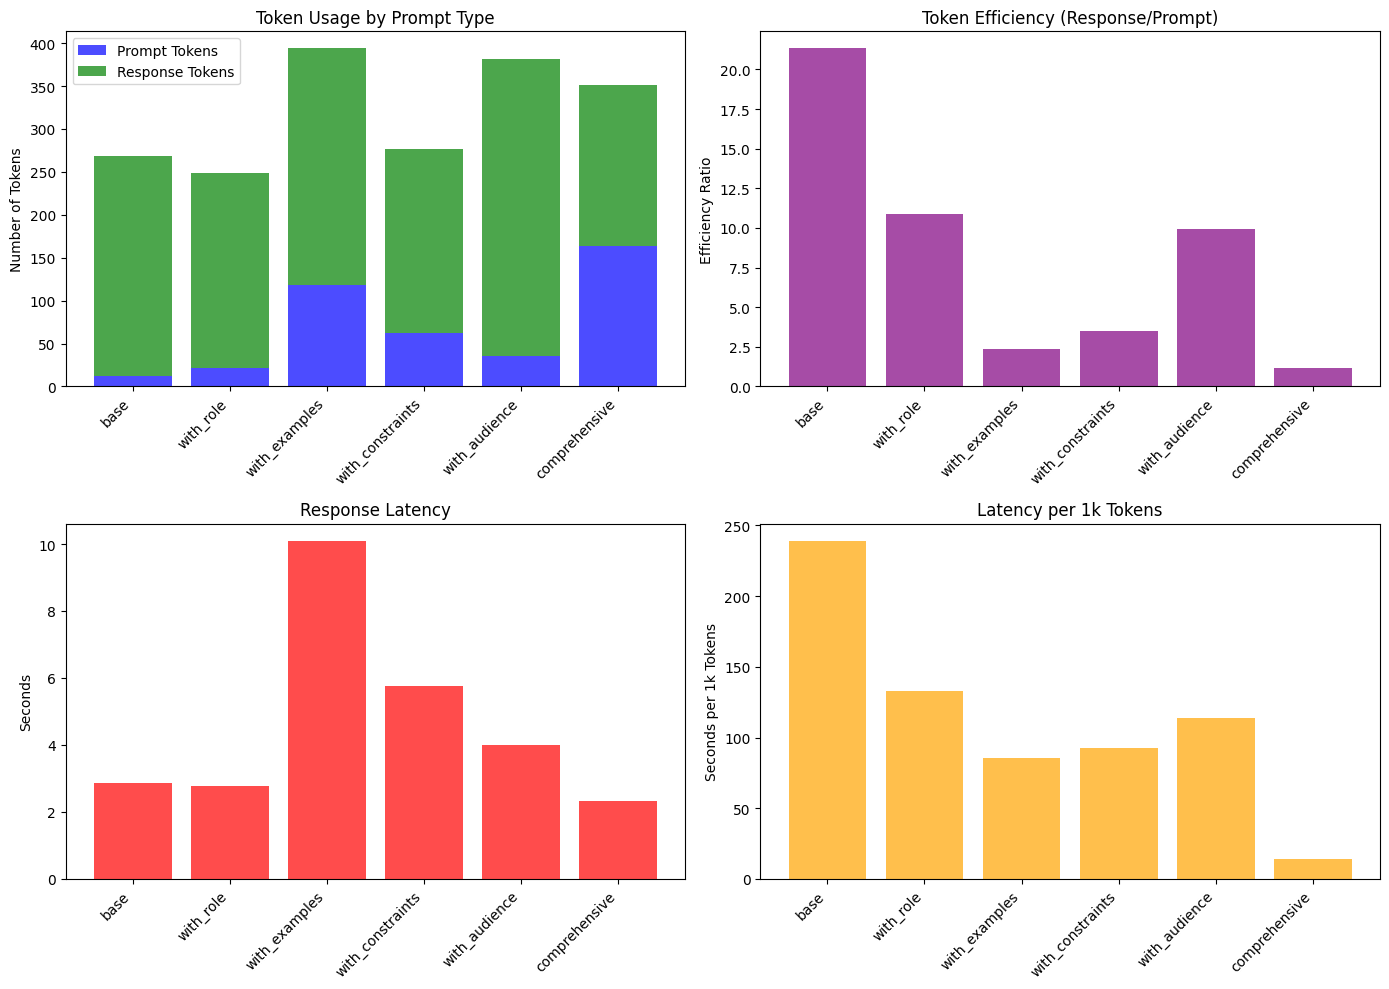

In [7]:
# 从 results 字典中提取用于绘图的数据
prompt_types = list(results.keys()) # 提示类型名称列表
prompt_tokens = [results[k]['prompt_tokens'] for k in prompt_types] # 各种提示的 Token 数量
response_tokens = [results[k]['response_tokens'] for k in prompt_types] # 各种响应的 Token 数量
latencies = [results[k]['latency'] for k in prompt_types] # 各种响应的时延

# 定义一个函数用于绘制指标的柱状图
def plot_bars():
    # 创建一个包含 2x2 子图的图表
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 第一个子图：Token Usage (提示 Token + 响应 Token)
    # Token Usage: 显示不同提示类型下，发送给模型的提示 Token 数量和模型返回的响应 Token 数量。
    # Token 是大模型处理文本的基本单位，Token 数量直接影响成本和处理时间。
    axes[0, 0].bar(prompt_types, prompt_tokens, label='Prompt Tokens', alpha=0.7, color='blue')
    axes[0, 0].bar(prompt_types, response_tokens, bottom=prompt_tokens, label='Response Tokens', alpha=0.7, color='green')
    axes[0, 0].set_title('Token Usage by Prompt Type')
    axes[0, 0].set_ylabel('Number of Tokens')
    axes[0, 0].legend()
    # 旋转 x 轴标签，避免重叠
    plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

    # 第二个子图：Token Efficiency (Response/Prompt)
    # Token Efficiency: 响应 Token 数量除以提示 Token 数量。
    # 表示模型生成响应的效率，高效率意味着用较少的提示 Token 获得了较多的响应 Token，这通常是期望的。
    token_efficiency = [results[k]['token_efficiency'] for k in prompt_types]
    axes[0, 1].bar(prompt_types, token_efficiency, color='purple', alpha=0.7)
    axes[0, 1].set_title('Token Efficiency (Response/Prompt)')
    axes[0, 1].set_ylabel('Efficiency Ratio')
    # 旋转 x 轴标签
    plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

    # 第三个子图：Response Latency
    # Response Latency: 从发送提示到接收完整响应所需的时间（以秒为单位）。
    # 反映模型的响应速度，时延越低，用户体验越好。
    latencies = [results[k]['latency'] for k in prompt_types]
    axes[1, 0].bar(prompt_types, latencies, color='red', alpha=0.7)
    axes[1, 0].set_title('Response Latency')
    axes[1, 0].set_ylabel('Seconds')
    # 旋转 x 轴标签
    plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

    # 第四个子图：Latency per 1k Tokens
    # Latency per 1k Tokens: 将总时延标准化到每处理 1000 个提示 Token 所需的时间（以毫秒为单位）。
    # 这个指标有助于比较不同提示长度下的模型性能，排除了因提示长度不同带来的绝对时延差异。
    latency_per_1k = [results[k]['latency_per_1k'] for k in prompt_types]
    axes[1, 1].bar(prompt_types, latency_per_1k, color='orange', alpha=0.7)
    axes[1, 1].set_title('Latency per 1k Tokens')
    axes[1, 1].set_ylabel('Seconds per 1k Tokens')
    # 旋转 x 轴标签
    plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

    # 自动调整子图布局，避免重叠
    plt.tight_layout()

# 检查是否安装了 matplotlib，如果安装了则绘制图表
if HAS_MPL:
    plot_bars(); # 调用绘图函数
    plt.show() # 显示图表
else:
    print('[未安装 matplotlib，跳过可视化]')

**输出图表解释：**

输出结果显示了四个柱状图，每个图都展示了不同“Prompt Type”（就是我们之前定义的各种提示，如 base、with_role、comprehensive 等）在某个指标上的表现。

1. Token Usage by Prompt Type (提示 Token + 响应 Token)
   - **图表内容：** 这个图展示了每种提示类型下，发送给模型的提示（Prompt）占用的 Token 数量（蓝色部分）以及模型返回的响应（Response）占用的 Token 数量（绿色部分）。总高度是本次交互的总 Token 数。
   - **解释：** Token 数量是使用大模型时非常关键的指标，因为它直接影响到调用的**成本**（大多数模型按 Token 收费）和模型的**处理能力**（模型有最大 Token 限制）。提示越长，发送的 Token 就越多，响应越长，返回的 Token 也越多。这个图告诉我们，不同的上下文扩展方式会显著改变提示的长度，从而影响总的 Token 消耗。例如，`comprehensive` 提示由于包含了多种信息，它的提示 Token 数量是最高的。
2. Token Efficiency (Response/Prompt)
   - **图表内容：** 这个图显示了模型响应的 Token 数量除以提示的 Token 数量的比值。
   - **解释：** 这个指标可以粗略衡量模型在给定提示下生成“有用”内容的效率。比值越高，意味着模型用相对较少的提示 Token 生成了较多的响应 Token。通常我们希望这个值高一些，但并非越高越好，关键是生成的响应要有**质量**且**相关**。基础提示 (`base`) 的效率看起来很高，但这可能是因为它提示非常简短，模型自由发挥空间大，生成的响应相对较长；而包含示例 (`with_examples`) 的提示，提示本身较长，但响应可能更聚焦，所以效率比 `base` 低。
3. Response Latency (时延)
   - **图表内容：** 这个图显示了从发送提示到接收模型完整响应所需的时间，单位是秒。
   - **解释：** 时延反映了模型的**响应速度**。对于需要快速响应的应用（比如实时聊天、自动化流程），时延是一个非常重要的指标。通常提示越长、模型越大，时延可能会越高，因为模型需要处理更多的信息。从图上看，`comprehensive` 提示的时延是最高的，这符合我们对长提示时延可能增加的预期。
4. Latency per 1k Tokens (每千 Token 的时延)
   - **图表内容：** 这个图显示的是将总时延标准化到每处理 1000 个提示 Token 所需的时间（单位是秒）。
   - **解释：** 这个指标是为了排除提示长度对时延的直接影响，更侧重于衡量模型处理单位长度输入的速度。比如，一个很长的提示时延高是正常的，但如果换算到每千 Token 的时延也很高，可能说明模型在这个任务或这种长度下处理效率不高。这个指标可以帮助我们比较不同策略在处理相同“工作量”（以 1k Token 衡量）时的相对速度。请注意，这个计算是基于**提示 Token**，所以提示 Token 为 0 或非常小的情况下，这个指标可能不太稳定或意义不大。从图上看，`with_examples` 的这个指标最低，可能是因为示例提供了清晰的结构和方向，模型处理起来更直接。

**总结：**

通过这四个图表，我们可以对比不同的上下文扩展策略如何影响 Token 使用、生成效率和响应速度。

- 增加上下文（如 `with_role`, `with_constraints`, `with_audience`, `comprehensive`）通常会**增加提示 Token 数量**。
- 提示长度增加通常会导致**总时延增加**。
- 不同类型的上下文对 Token 效率和标准化时延的影响各不相同，这取决于上下文的内容和模型如何利用这些信息。例如，提供好的 `examples` 可能会让模型更快地生成符合要求的响应，即使提示变长，标准化时延反而可能降低。

通过分析这些图表，你可以更好地理解在实际应用中，选择哪种上下文扩展方式需要在**提升输出质量**和**控制成本/时延**之间进行权衡。

### 3. 模板化：扩展上下文生成器
“模板化：扩展上下文生成器”这部分代码做了什么，以及它的输出对大模型技术初学者有什么启发。

这部分代码的核心是定义了一个 `create_expanded_context` 函数。这个函数就像一个“提示词构建工具”，它可以根据你提供的信息（比如你想让模型扮演什么角色、你想让它为谁写、有哪些具体要求等等），帮你把这些信息有条理地组合起来，生成一个更丰富、更具体的提示词。

代码中用一个例子演示了这个函数的使用：

1. **基础任务**：让模型为一个期末考试后去上海的大学生规划三天旅游路线。
2. **添加各种“修饰”信息**：指定模型是“熟悉上海的资深旅行博主”（角色），受众是“期末考试后放松的大学生”（受众），语气要“活泼有趣且实用”（语气），还列出了一些具体的“要求”（约束），甚至提供了一个“示例”（示例）。
3. **生成扩展提示词**：`create_expanded_context` 函数把这些信息整合成一个完整的提示词。
4. **调用模型并分析**：用这个生成的提示词去调用大模型，并计算了响应的 Token 数量。

In [8]:
from typing import Optional

# 创建一个函数，根据传入的参数动态生成扩展上下文
def create_expanded_context(
    base_prompt: str, # 基础提示，核心任务
    role: Optional[str] = None, # 可选：指定模型扮演的角色
    examples: Optional[List[str]] = None, # 可选：提供示例
    constraints: Optional[List[str]] = None, # 可选：指定约束或要求
    audience: Optional[str] = None, # 可选：指定目标受众
    tone: Optional[str] = None, # 可选：指定输出的语气
    output_format: Optional[str] = None, # 可选：指定输出的格式
) -> str:
    parts: List[str] = [] # 用于存储构建上下文的各个部分
    if role:
        parts.append(f"你的身份：{role}。") # 添加角色信息
    parts.append(base_prompt) # 添加基础提示
    if audience:
        parts.append(f"请确保你的回答适合：{audience}。") # 添加受众信息
    if tone:
        parts.append(f"请使用 {tone} 的语气进行回答。") # 添加语气信息
    if output_format:
        parts.append(f"请将输出格式化为：{output_format}。") # 添加输出格式信息
    if constraints:
        parts.append("要求：") # 添加约束部分标题
        parts.extend([f"- {c}" for c in constraints]) # 以列表形式添加具体约束
    if examples:
        parts.append("示例：") # 添加示例部分标题
        parts.extend([f"示例 {i+1}：\n{ex}" for i, ex in enumerate(examples)]) # 以编号列表形式添加示例
    # 使用双换行符将各个部分连接起来，形成最终的扩展上下文
    return "\n\n".join(parts)

# 定义一个新的基础提示用于测试
new_base_prompt = "请为期末考试后去上海的大学生，规划一个为期三天的旅游路线。"
# 使用 create_expanded_context 函数生成一个包含多种上下文层的扩展上下文
new_expanded_context = create_expanded_context(
    base_prompt=new_base_prompt, # 基础提示
    role="一位熟悉上海的资深旅行博主", # 角色
    audience="期末考试后放松的大学生", # 受众
    tone="活泼有趣且实用", # 语气
    constraints=[ # 约束列表
        "包含至少一个历史文化景点",
        "包含至少一个现代都市景点",
        "包含至少一个美食体验",
        "考虑交通便捷性",
        "行程安排不要过于紧凑",
    ],
    examples=[ # 示例列表
        "第一天：上午抵达上海，入住酒店。下午去外滩感受老上海风情，晚上可以去南京路步行街逛街和品尝小吃。",
    ],
)

# 打印生成的扩展上下文
print("模板生成的扩展上下文后的提示：\n", new_expanded_context)
print("="*100)
# 使用生成的扩展上下文调用模型生成响应
resp, lat = generate_response(new_expanded_context)
# 计算并打印响应的 Token 数量
metrics = calculate_metrics(new_expanded_context, resp, lat)
print("\n响应：\n", resp)
print("响应 token：", metrics["response_tokens"])

模板生成的扩展上下文后的提示：
 你的身份：一位熟悉上海的资深旅行博主。

请为期末考试后去上海的大学生，规划一个为期三天的旅游路线。

请确保你的回答适合：期末考试后放松的大学生。

请使用 活泼有趣且实用 的语气进行回答。

要求：

- 包含至少一个历史文化景点

- 包含至少一个现代都市景点

- 包含至少一个美食体验

- 考虑交通便捷性

- 行程安排不要过于紧凑

示例：

示例 1：
第一天：上午抵达上海，入住酒店。下午去外滩感受老上海风情，晚上可以去南京路步行街逛街和品尝小吃。

响应：
 嘿，亲爱的大学生们！期末考试终于结束，放松的时刻来啦！来一场说走就走的上海之旅吧！我为你们精心策划了一条活力满满的三天行程，让你们享受到历史、现代和美食的完美结合！准备好了吗？出发！

### 第一天：历史与人文之旅

**上午：抵达上海，入住酒店**  
选择一个靠近地铁的酒店，方便后续的出行哦！比如在人民广场附近的酒店，交通相当便利。

**下午：游览豫园与城隍庙**  
豫园是个充满江南古典韵味的地方，漫步在古色古香的园林中，感受历史的厚重。别忘了拍些美照哦！逛完豫园，步行去附近的城隍庙，体验一下传统的市场氛围，感受老上海的魅力。

**晚上：美食体验**  
在城隍庙附近的小吃街，尝尝正宗的小笼包、汤包和生煎，当然还有那令人垂涎的糖葫芦！吃饱后可以在附近的南翔小笼包店坐坐，和小伙伴们分享一下考试后的心情。

### 第二天：现代都市风情

**上午：逛陆家嘴金融区**  
早上可以去陆家嘴，登上上海中心大厦的观光厅，俯瞰整个上海的壮丽景色，感受现代都市的活力与魅力。记得提前预约门票哦，避免排长队！

**中午：黄浦江边的午餐**  
在陆家嘴附近找一家江边餐厅，享用一顿美味的午餐。推荐去“外滩三号”餐厅，既能享受美食，又能欣赏到黄浦江的美景！

**下午：外滩漫步**  
餐后可以沿着黄浦江边漫步，欣赏外滩的经典建筑，拍照打卡，和朋友们一起感受这个城市的韵味。

**晚上：南京路步行街购物**  
晚上去南京路步行街，尽情购物，体验上海的夜生活！可以尝试一些街头小吃，比如炸串和冰淇淋，边逛边吃，乐趣无穷！

### 第三天：艺术与休闲

**上午：上海博物馆**  
今天可以选择去上海博物馆，那里有丰富的历史文物和艺术作品，适合喜欢文化的小伙伴。馆内的展

**结合输出信息，我们可以得出以下结论，这对初学者很有帮助：**

- **提示词不是越简单越好**：原始的基础提示词很短，但可能不够明确。通过添加角色、受众、要求、示例等信息，我们可以构建一个更详细、更具指导性的提示词。
- **结构化的信息更有用**：`create_expanded_context` 函数将不同的信息分块（如“你的身份”、“请确保你的回答适合”、“要求”、“示例”等），并用换行符和冒号等分隔，这使得提示词结构清晰，模型更容易理解我们的意图。
- **更多的上下文意味着更长的提示词**：从输出可以看到，经过模板化生成的扩展提示词比基础提示词长得多。这直接导致发送给模型的 Token 数量增加。
- **长提示词的权衡**：虽然长提示词可以帮助模型更好地理解任务并生成更符合要求的回答（就像示例中生成的详细旅游路线），但它也会增加调用的成本（因为通常按 Token 收费）和可能的时延。

**对初学者的启示：**

上下文工程（Prompt Engineering）不仅仅是写一句话让模型回答。它更像是在给模型“写一份详细的说明书”。通过“模板化”的方式，你可以系统地思考需要给模型哪些信息，并把这些信息组织好，从而：

1. **提高模型输出的质量和相关性**：明确的角色、受众和要求能引导模型生成更贴合你需求的回答。
2. **减少尝试次数**：一开始就提供清晰的上下文，可以减少因为提示词不明确而需要反复修改和测试的次数。
3. **理解成本与效果的平衡**：虽然增加上下文会增加 Token 成本，但如果能显著提升输出质量，这个成本是值得的。你需要根据具体的应用场景来权衡。
4. **构建可复用的提示结构**：将常用的上下文层（如角色、要求）模板化，可以在不同的任务中快速构建高质量的提示词。

总之，“模板化：扩展上下文生成器”这个例子展示了如何系统地构建更有效的提示词，帮助你更好地利用大模型解决具体问题，同时让你初步了解上下文长度对模型调用的影响。

### 4. 上下层优化（Layer Optimization）

对不同上下文层的组合进行系统测试，比较指标与最优配置。

这部分代码的核心是进行一个系统性的测试，目的是找出不同“上下文层”（比如角色、需求、受众等）的组合对大模型生成响应的影响。它通过以下步骤来完成：

1. **定义基础提示和上下文层**：首先确定一个核心任务（基础提示），然后定义一些可以添加到这个基础提示上的额外信息，也就是不同的上下文层。

2. **测试不同的组合**：代码依次测试了只使用基础提示、基础提示加上每一个单独的上下文层，以及基础提示加上所有上下文层的组合。

3. 测量和比较指标

   ：对于每一种提示组合，代码都调用大模型生成响应，并测量了几个关键指标：

   - **提示 Token**：发送给模型的提示的长度。
   - **响应 Token**：模型生成的响应的长度。
   - **时延**：模型生成响应所需的时间。
   - **Token 效率**：响应 Token / 提示 Token 的比值，粗略衡量模型生成内容的效率。


In [9]:
def test_layered_contexts(base_prompt: str, context_layers: Dict[str, str]) -> Dict[str, Dict[str, Any]]:
    """
    测试不同上下文层组合的效果。

    Args:
        base_prompt: 基础提示。
        context_layers: 一个字典，键是上下文层的名称，值是对应的文本内容。

    Returns:
        一个字典，键是测试的配置名称（e.g., "base", "base+role", "all_layers"），
        值是包含该配置的提示、响应和指标的字典。
    """
    layer_results: Dict[str, Dict[str, Any]] = {} # 存储测试结果
    print("测试：base")
    # 测试基础提示
    base_resp, base_lat = generate_response(base_prompt)
    base_metrics = calculate_metrics(base_prompt, base_resp, base_lat)
    layer_results["base"] = {
        "prompt": base_prompt,
        "response": base_resp,
        **base_metrics,
    }
    print(f"  提示 token: {base_metrics['prompt_tokens']}, 响应 token: {base_metrics['response_tokens']}, 时延: {base_metrics['latency']:.2f}s, 效率: {base_metrics['token_efficiency']:.2f}")

    # 测试基础提示 + 单个上下文层
    for layer_name, layer_content in context_layers.items():
        name = f"base+{layer_name}"
        prompt = f"{base_prompt}\n\n{layer_content}" # 构建组合提示
        print(f"测试：{name}")
        resp, lat = generate_response(prompt)
        metrics = calculate_metrics(prompt, resp, lat)
        layer_results[name] = {
            "prompt": prompt,
            "response": resp,
            **metrics,
        }
        print(f"  提示 token: {metrics['prompt_tokens']}, 响应 token: {metrics['response_tokens']}, 时延: {metrics['latency']:.2f}s, 效率: {metrics['token_efficiency']:.2f}")

    # 测试基础提示 + 所有上下文层
    all_layers = "\n\n".join(context_layers.values())
    full_prompt = f"{base_prompt}\n\n{all_layers}"
    print("测试：all_layers")
    full_resp, full_lat = generate_response(full_prompt)
    full_metrics = calculate_metrics(full_prompt, full_resp, full_lat)
    layer_results["all_layers"] = {
        "prompt": full_prompt,
        "response": full_resp,
        **full_metrics,
    }
    print(f"  提示 token: {full_metrics['prompt_tokens']}, 响应 token: {full_metrics['response_tokens']}, 时延: {full_metrics['latency']:.2f}s, 效率: {full_metrics['token_efficiency']:.2f}")

    return layer_results

# 定义用于层测试的基础提示和上下文层
layer_test_prompt = "请为期末考试后去成都的大学生，规划一个为期四天的旅游路线。"
context_layers = {
    "role": "你的身份：一位熟悉成都的资深旅行博主。", # 角色层
    "requirements": "需求：\n- 包含大熊猫基地\n- 包含宽窄巷子或锦里\n- 包含至少一种地道川菜体验\n- 行程节奏轻松，适合学生", # 需求层
    "audience": "目标受众：期末考试后放松的大学生，预算适中。", # 受众层
}
# 执行层测试并获取结果
layer_test_results = test_layered_contexts(layer_test_prompt, context_layers)

# 根据 Token 效率找到表现最好的配置
# 注意：这里以 token_efficiency 作为衡量标准，实际应用中可能需要结合其他指标（如质量评分）
best = max(layer_test_results.keys(), key=lambda k: layer_test_results[k]['token_efficiency'])
print("\nToken 效率最高配置：", best)

测试：base
  提示 token: 22, 响应 token: 626, 时延: 6.86s, 效率: 28.45
测试：base+role
  提示 token: 37, 响应 token: 799, 时延: 31.38s, 效率: 21.59
测试：base+requirements
  提示 token: 67, 响应 token: 745, 时延: 6.10s, 效率: 11.12
测试：base+audience
  提示 token: 40, 响应 token: 800, 时延: 25.99s, 效率: 20.00
测试：all_layers
  提示 token: 101, 响应 token: 800, 时延: 6.91s, 效率: 7.92

Token 效率最高配置： base


### 5. 上下文压缩（摘要/关键词/要点）

这部分代码展示了如何通过对长上下文进行压缩来减少提示词的长度，并对比了使用摘要、关键词和要点三种压缩技术后的效果。

不同的压缩方式保留信息的方式不同：

- **摘要**保留了原始上下文的主要思想和流畅性。
- **关键词**提取了核心概念，但丢失了原文的结构和细节。
- **要点**将信息结构化，有助于清晰呈现关键信息。


In [15]:
# 定义一个函数用于压缩上下文
def compress_context(context: str, technique: str = 'summarize') -> str:
    """
    使用不同技术压缩上下文。

    Args:
        context: 需要压缩的原始上下文。
        technique: 压缩技术，可选 'summarize', 'keywords', 'bullet'。

    Returns:
        压缩后的上下文。
    """
    # 根据指定的压缩技术构建相应的提示
    if technique == 'summarize':
        prompt = f"请精炼以下关于旅游路线规划的上下文，保留关键信息并减少冗余：\n\n{context}"
    elif technique == 'keywords':
        prompt = f"请提取以下关于旅游路线规划的上下文的关键词与关键短语（逗号分隔）：\n\n{context}"
    elif technique == 'bullet':
        prompt = f"请将以下关于旅游路线规划的上下文转换为结构化要点列表，覆盖核心信息：\n\n{context}"
    else:
        return context # 如果技术未知，返回原始上下文
    # 调用模型生成压缩后的内容
    resp, _ = generate_response(prompt)
    return resp

# 使用之前定义的 comprehensive 提示作为原始上下文进行压缩测试
original_context = expanded_prompts["comprehensive"]
print("--- 原始上下文 ---")
print(original_context)
print("原始 token：", count_tokens(original_context))

# 遍历不同的压缩技术进行测试
compressed_prompts = {}
for tech in ['summarize', 'keywords', 'bullet']:
    out = compress_context(original_context, tech) # 执行压缩
    compressed_prompts[tech] = out
    print(f"\n--- {tech.upper()} ---") # 打印技术名称
    print(out) # 打印压缩后的内容
    print("压缩后 token：", count_tokens(out)) # 打印压缩后的 Token 数量

print("\n" + "="*50)
print("--- 生成内容对比 ---")

# 生成原始提示词的响应
print("\n--- 原始提示词生成内容 ---")
original_response, original_latency = generate_response(original_context)
original_metrics = calculate_metrics(original_context, original_response, original_latency)
print(original_response)
print(f"  提示 token: {original_metrics['prompt_tokens']}, 响应 token: {original_metrics['response_tokens']}, 时延: {original_metrics['latency']:.2f}s, 效率: {original_metrics['token_efficiency']:.2f}")


# 生成压缩后提示词的响应
for tech, compressed_prompt in compressed_prompts.items():
    print(f"\n--- {tech.upper()} 压缩后提示词生成内容 ---")
    compressed_response, compressed_latency = generate_response(compressed_prompt)
    compressed_metrics = calculate_metrics(compressed_prompt, compressed_response, compressed_latency)
    print(compressed_response)
    print(f"  提示 token: {compressed_metrics['prompt_tokens']}, 响应 token: {compressed_metrics['response_tokens']}, 时延: {compressed_metrics['latency']:.2f}s, 效率: {compressed_metrics['token_efficiency']:.2f}")

--- 原始上下文 ---
你是一名专业的旅游规划师。

请为第一次计划自由行的大学生，写一段关于旅游路线规划的说明文字，
使用简单易懂的语言和实用的建议。

写作指南：
- 至少包含三个关键考虑因素（如预算、时间、偏好）
- 提及规划的好处
- 以‘开始你的规划吧！’结尾
- 保持实用且易于理解的语气

语气与结构示例：
计划一次旅行就像是画一张寻宝图，每一步都很重要。首先，定好你的目的地和大概的旅行日期。然后，考虑你的预算，这会影响你的交通和住宿选择。别忘了你的兴趣，是喜欢自然风光还是城市探索？
原始 token： 164

--- SUMMARIZE ---
作为一名专业的旅游规划师，我为第一次自由行的大学生提供一些实用建议。首先，明确你的预算，这将帮助你选择合适的交通和住宿方式。其次，考虑你的时间安排，确保你能充分体验每个景点而不至于匆忙。最后，思考你的个人偏好，是偏爱美食、文化还是冒险活动？合理规划能让你的旅行更加顺利和愉快。开始你的规划吧！
压缩后 token： 103

--- KEYWORDS ---
关键词与关键短语：旅游规划, 自由行, 大学生, 预算, 时间, 偏好, 规划的好处, 目的地, 旅行日期, 交通, 住宿选择, 自然风光, 城市探索, 开始你的规划吧！
压缩后 token： 61

--- BULLET ---
### 旅游路线规划要点

1. **确定目的地与日期**
   - 选择你想去的地方。
   - 确定旅行的时间段。

2. **考虑预算**
   - 设定总预算，包括交通、住宿、饮食和活动费用。
   - 根据预算选择合适的交通工具（如飞机、火车或汽车）和住宿类型（如酒店、民宿或青旅）。

3. **了解个人偏好**
   - 思考自己喜欢的活动类型：自然景观、历史文化还是美食体验？
   - 制定行程时，确保安排符合你的兴趣。

4. **规划的好处**
   - 旅行前的规划可以帮助你节省时间和金钱。
   - 让你更好地掌握行程，避免临时的麻烦和不必要的支出。

5. **开始你的规划吧！**
压缩后 token： 197

--- 生成内容对比 ---

--- 原始提示词生成内容 ---
计划一次自由行就像是为自己的冒险编写剧本，每一个细节都能让你的旅程更顺利。首先，确定你的目的地和旅行时间，这能帮助你更好地

### 6. 上下文修剪：系统化删除无效层（可选）

使用模型自评来比较不同层组合下的质量分，并递归删除无效层。

展示一种**更系统、更数据驱动**的方法来优化提示词中的上下文层。

它的核心逻辑是：

1. **定义评估标准**：首先，明确你希望模型生成的响应在哪些方面是“好”的（例如，是否包含所有要求的信息、语气是否合适、结构是否清晰等）。
2. **模型自评**：利用模型本身的评估能力，让它根据你定义的标准给不同提示词组合生成的响应打分。
3. **系统性测试和修剪**：代码会测试包含不同上下文层组合的提示词（例如，只包含基础提示、包含基础+角色、包含基础+角色+约束等），并评估它们的质量得分和 Token 数量。
4. **递归优化（概念）**：理论上，你可以通过比较不同组合的效果，识别出那些增加了提示词长度（Token 数量）但对提高响应质量帮助不大的上下文层，然后将它们移除，甚至进行递归的修剪过程，直到找到一个在质量和成本之间达到最佳平衡的提示词结构。


In [17]:
import re

# 定义一个函数，让模型评估生成响应的质量
def evaluate_response_quality(prompt: str, response: str, criteria: List[str]) -> float:
    """
    使用模型评估响应质量并提取总体评分。

    Args:
        prompt: 用于生成响应的提示。
        response: 需要评估的响应。
        criteria: 用于评估响应的质量标准列表。

    Returns:
        总体评分 (0.0-1.0)，如果无法提取评分则返回 0.5。
    """
    # 构建用于评估的提示，包含原始提示、响应和评估标准
    crit = "\n".join([f"- {c}" for c in criteria]) # 格式化评估标准
    eval_prompt = (
        "请为以下关于旅游路线规划的响应基于标准打分，最后给出‘总体评分：0.0-1.0’。\n\n"
        f"提示：\n{prompt}\n\n响应：\n{response}\n\n评估标准：\n{crit}\n"
    )
    # 调用模型生成评估结果
    eval_resp, _ = generate_response(eval_prompt)
    # 使用正则表达式从评估结果中提取总体评分
    m = re.findall(r"总体评分[:：]\s*([0-9]*\.?[0-9]+)", eval_resp)
    # 如果提取到评分，返回最后一个评分（处理可能有多个评分的情况），否则返回 0.5
    return float(m[-1]) if m else 0.5

# 定义一个函数，通过递归方式修剪上下文层
def prune_context_layers(base_prompt: str, layers: Dict[str, str], criteria: List[str]) -> Tuple[str, Dict[str, Any]]:
    """
    系统性地修剪上下文层，保留对质量提升有益的层。

    Args:
        base_prompt: 基础提示。
        layers: 需要测试和修剪的上下文层字典。
        criteria: 用于评估响应质量的标准列表。

    Returns:
        最优的提示字符串和包含所有测试结果的字典。
    """
    print("--- 开始上下文层修剪测试 ---")
    results: Dict[str, Any] = {} # 存储测试结果

    # 1. 测试基础提示的质量
    print("测试：base")
    base_resp, _ = generate_response(base_prompt)
    base_quality = evaluate_response_quality(base_prompt, base_resp, criteria)
    base_tokens = count_tokens(base_prompt)
    results["base"] = {"prompt": base_prompt, "quality": base_quality, "tokens": base_tokens}
    print(f"  基础提示质量：{base_quality:.2f}, Token: {base_tokens}")

    # 如果没有上下文层需要测试，直接返回基础提示结果
    if not layers:
        print("--- 没有可修剪的上下文层 ---")
        return base_prompt, results

    # 2. 测试包含所有上下文层的提示的质量
    all_text = "\n\n".join(layers.values())
    full_prompt = f"{base_prompt}\n\n{all_text}"
    print("测试：all_layers")
    full_resp, _ = generate_response(full_prompt)
    full_quality = evaluate_response_quality(full_prompt, full_resp, criteria)
    full_tokens = count_tokens(full_prompt)
    results["all_layers"] = {"prompt": full_prompt, "quality": full_quality, "tokens": full_tokens}
    print(f"  所有层组合质量：{full_quality:.2f}, Token: {full_tokens}")

    best_quality = full_quality # 初始化最佳质量为所有层组合的质量
    best_key = "all_layers" # 初始化最佳配置为所有层组合

    # 3. 逐个移除上下文层并测试剩余组合的质量
    current_layers = layers.copy() # 复制当前上下文层字典
    removed_layer = None # 记录当前轮次移除的层

    # 尝试移除每个层，看看是否能提高或保持质量同时减少 Token
    for name in list(current_layers.keys()):
        remain = {k: v for k, v in current_layers.items() if k != name} # 移除当前层后的剩余层
        test_prompt = f"{base_prompt}\n\n" + "\n\n".join(remain.values()) # 构建测试提示
        print(f"测试：without_{name}")
        test_resp, _ = generate_response(test_prompt)
        q = evaluate_response_quality(test_prompt, test_resp, criteria) # 评估质量
        key = f"without_{name}"
        test_tokens = count_tokens(test_prompt)
        results[key] = {"prompt": test_prompt, "quality": q, "tokens": test_tokens}
        print(f"  移除 {name} 后质量：{q:.2f}, Token: {test_tokens}")

        # 判断当前组合是否是更好的选择：
        # 如果质量显著提升（例如 > 0.05），或者质量相当但 Token 减少，则更新最佳配置
        if q > best_quality + 0.05: # 质量显著提升
             best_quality, best_key = q, key
             removed_layer = name
        elif abs(q - best_quality) <= 0.05 and test_tokens < results[best_key]["tokens"]: # 质量相当但 Token 减少
             best_quality, best_key = q, key
             removed_layer = name

    print(f"本轮最佳配置：{best_key}, 质量: {best_quality:.2f}, Token: {results[best_key]['tokens']}")

    # 4. 递归调用：如果本轮移除了层并找到了更好的配置，则基于剩余层继续修剪
    if removed_layer:
        print(f"发现可移除层：{removed_layer}，继续修剪...")
        new_layers = {k: v for k, v in current_layers.items() if k != removed_layer}
        # 将当前轮次的结果合并到下一轮的 results 中
        next_prompt, next_results = prune_context_layers(base_prompt, new_layers, criteria)
        results.update(next_results) # 合并结果
        return next_prompt, results
    else:
        # 如果本轮没有移除任何层，说明已经找到局部最优解或无法进一步优化
        print("--- 修剪完成，未发现更多可移除层 ---")
        return results[best_key]["prompt"], results # 返回最佳提示和所有测试结果

# 示例用法：定义基础提示、上下文层和评估标准
prune_test_prompt = "请为期末考试后去北京的大学生，规划一个为期五天的旅游路线。"
prune_context_layers_dict = {
    "role": "你的身份：一位熟悉北京的资深旅行博主。",
    "audience": "目标读者：期末考试后放松的大学生，对历史文化和现代都市都感兴趣。",
    "constraints": "要求：\n- 包含故宫和长城\n- 包含至少一个艺术区或创意园区\n- 包含至少一种北京特色小吃体验\n- 考虑公共交通便捷性\n- 行程安排劳逸结合",
    "example": "示例：\n第一天：上午抵达北京，前往酒店。下午参观故宫，感受皇家气派。晚上可以在王府井大街品尝北京烤鸭。\n第二天：上午前往慕田峪长城，体验壮丽景色。下午返回市区，参观798艺术区。",
}
prune_criteria = [
    "行程规划是否合理，考虑了交通和节奏？",
    "是否包含了故宫和长城？",
    "是否包含了至少一个艺术区或创意园区？",
    "是否包含了至少一种北京特色小吃体验？",
    "是否适合期末考试后放松的大学生？",
    "作为旅行博主，语气是否专业且有吸引力？",
]

# 执行上下文层修剪过程
pruned_prompt, prune_results = prune_context_layers(prune_test_prompt, prune_context_layers_dict, prune_criteria)
print("\n--- 修剪结果 ---")
print("最优提示：\n", pruned_prompt)
print("\n各配置测试结果：")
for key, res in prune_results.items():
   print(f"  {key}: 质量={res['quality']:.2f}, Token={res['tokens']}")

# 注意：模型自评可能引入不稳定性

--- 开始上下文层修剪测试 ---
测试：base
  基础提示质量：0.90, Token: 22
测试：all_layers
  所有层组合质量：1.00, Token: 186
测试：without_role
  移除 role 后质量：0.95, Token: 171
测试：without_audience
  移除 audience 后质量：1.00, Token: 163
测试：without_constraints
  移除 constraints 后质量：1.00, Token: 133
测试：without_example
  移除 example 后质量：0.95, Token: 112
本轮最佳配置：without_constraints, 质量: 1.00, Token: 133
发现可移除层：constraints，继续修剪...
--- 开始上下文层修剪测试 ---
测试：base
  基础提示质量：0.90, Token: 22
测试：all_layers
  所有层组合质量：0.90, Token: 133
测试：without_role
  移除 role 后质量：1.00, Token: 118
测试：without_audience
  移除 audience 后质量：1.00, Token: 110
测试：without_example
  移除 example 后质量：0.90, Token: 60
本轮最佳配置：without_audience, 质量: 1.00, Token: 110
发现可移除层：audience，继续修剪...
--- 开始上下文层修剪测试 ---
测试：base
  基础提示质量：0.90, Token: 22
测试：all_layers
  所有层组合质量：1.00, Token: 110
测试：without_role
  移除 role 后质量：1.00, Token: 95
测试：without_example
  移除 example 后质量：0.90, Token: 37
本轮最佳配置：without_role, 质量: 1.00, Token: 95
发现可移除层：role，继续修剪...
--- 开始上下文层修剪测试 ---
测试：base
  基础提示质量：1.00, Toke

- **上下文工程可以更科学**：提示词优化不仅仅是凭感觉或经验，可以通过定义明确的评估标准，并利用模型或人工评估来量化不同策略的效果。
- **并非所有上下文都有益**：增加上下文并不总是能提升模型表现。有些信息可能冗余，甚至会干扰模型理解核心任务。
- **需要系统性测试来找到最优解**：通过测试不同的上下文层组合，才能找到在你的特定任务中既能保证质量又能控制成本（Token）的最佳提示词结构。
- **模型自评是一种潜在工具**：虽然模型自评可能引入不稳定性（模型评估自己可能会有偏见或不一致），但它提供了一种自动化的方式来初步评估不同提示词的效果，可以作为人工评估的补充或初步筛选工具。
- **“修剪”的重要性**：学会如何识别和移除提示词中“无效”或低效的上下文层，是控制成本和提升模型处理效率的关键技巧。

### 7. 结合检索（RAG）

用简单关键词匹配演示从“知识库”取回信息并拼接到提示中。

这部分代码的核心是引入了 **检索增强生成（Retrieval Augmented Generation, RAG）** 的概念。它的基本思想是：当模型需要回答一个问题或完成一个任务时，不是仅仅依靠其内置的知识，而是先从一个外部的知识库中**检索**出与当前任务或问题相关的**信息**，然后将这些检索到的信息作为额外的**上下文**添加到提示词中，最后让模型基于这个包含外部信息的提示词来**生成**响应。

代码中用一个简化的例子演示了这个过程：

1. **模拟知识库**：创建了一个包含一些旅游规划相关基础知识的简单列表作为“知识库”。
2. **模拟检索**：定义了一个 `retrieve_relevant_info` 函数，它根据输入的查询（比如“旅游规划 自由行 步骤”）在这个模拟知识库中进行简单的关键词匹配，找出相关的知识条目。
3. **构建 RAG 上下文**：定义了一个 `create_rag_context` 函数，它将原始的基础提示和检索到的相关信息组合起来，形成一个包含外部知识的“RAG 上下文”。
4. **调用模型生成响应**：使用这个包含检索信息的 RAG 上下文去调用大模型，并打印模型生成的响应。

In [12]:
from typing import Dict as TDict

# 模拟一个简单的知识库，包含一些关于旅游规划的信息
kb = [
    {"title": "旅游规划基础", "content": "旅游规划是制定旅行行程的过程，包括选择目的地、交通方式、住宿、景点和活动等。"},
    {"title": "选择目的地", "content": "选择目的地需要考虑旅行时间、预算、旅行偏好（如文化、自然、探险）以及同行人员。"},
    {"title": "交通方式选择", "content": "常见的交通方式包括飞机、火车、汽车和轮船。选择哪种方式取决于目的地距离、预算和时间。"},
    {"title": "住宿预订", "content": "住宿类型多样，如酒店、民宿、青年旅社等。预订时需考虑位置、价格、设施和评价。"},
    {"title": "景点和活动安排", "content": "根据兴趣和时间安排参观景点和参与活动，注意开放时间、门票信息和预约需求。"},
    {"title": "预算控制", "content": "提前制定预算，包括交通、住宿、餐饮、门票、购物等各项开支，并在旅行中尽量遵守。"},
    {"title": "打包行李", "content": "根据目的地气候、旅行天数和活动内容准备衣物、洗漱用品、药品和必要证件。"},
    {"title": "安全注意事项", "content": "了解目的地安全情况，保管好个人财物，遵守当地法律法规，购买旅行保险。"},
]

# 定义一个函数，根据用户查询从知识库中检索相关信息
def retrieve_relevant_info(query: str, knowledge_base: List[TDict[str, str]]) -> List[str]:
    """
    根据查询从知识库中检索相关信息。

    Args:
        query: 用户查询字符串。
        knowledge_base: 知识库，包含字典列表，每个字典有 'title' 和 'content' 键。

    Returns:
        一个包含检索到的相关信息内容字符串的列表，按相关度降序排列（最多返回 3 条）。
    """
    q_terms = set(query.lower().split()) # 将查询转换为小写单词集合
    hits: List[Tuple[int, str]] = [] # 存储匹配到的信息和得分
    for item in knowledge_base:
        content = item['content'].lower() # 知识库内容转小写
        title = item['title'].lower() # 知识库标题转小写
        # 计算查询词在内容或标题中出现的次数作为得分
        score = sum(1 for t in q_terms if t in content or t in title)
        if score > 0: # 只添加有匹配得分的信息
            hits.append((score, item['content']))
    hits.sort(key=lambda x: x[0], reverse=True) # 按得分降序排序
    return [h[1] for h in hits[:3]] # 返回得分最高的 3 条信息内容

# 定义一个函数，将检索到的信息添加到基础提示中构建 RAG 上下文
def create_rag_context(base_prompt: str, query: str, kb_list: List[TDict[str, str]]) -> str:
    """
    创建结合检索增强的上下文。

    Args:
        base_prompt: 基础提示。
        query: 用于检索的查询。
        kb_list: 知识库列表。

    Returns:
        结合了检索信息的扩展提示。
    """
    infos = retrieve_relevant_info(query, kb_list) # 检索相关信息
    if not infos:
        return base_prompt # 如果没有检索到信息，返回基础提示
    # 如果检索到信息，将信息添加到提示后面
    return base_prompt + "\n\n相关信息：\n\n" + "\n\n".join(infos)

# 定义一个用于 RAG 测试的提示和查询
rag_prompt = "请简要讲解如何规划一次自由行。"
rag_query = "旅游规划 自由行 步骤" # 用于检索的关键词
# 创建 RAG 上下文
rag_ctx = create_rag_context(rag_prompt, rag_query, kb)
# 打印 RAG 上下文
print("--- RAG 上下文 ---")
print(rag_ctx)
# 使用 RAG 上下文调用模型生成响应
rag_resp, _ = generate_response(rag_ctx)
# 打印 RAG 响应
print("\n--- RAG 响应 ---")
print(rag_resp)

--- RAG 上下文 ---
请简要讲解如何规划一次自由行。

相关信息：

旅游规划是制定旅行行程的过程，包括选择目的地、交通方式、住宿、景点和活动等。

--- RAG 响应 ---
规划一次自由行可以按照以下步骤进行：

1. **确定目的地**：
   - 根据个人兴趣、预算和时间选择目的地。可以考虑自然风光、文化历史、美食等因素。

2. **制定旅行时间**：
   - 确定旅行的起止日期，考虑天气、节假日和旅游高峰期等。

3. **交通方式**：
   - 查阅目的地的交通情况，选择合适的交通方式（如飞机、火车、汽车等）。提前预订机票和车票，确保顺利出行。

4. **住宿选择**：
   - 根据预算和需求选择住宿类型（酒店、民宿、青旅等）。可以通过各大旅游平台进行比较和预订。

5. **规划行程**：
   - 列出想要参观的景点和参加的活动，合理安排每天的行程，注意留出自由活动时间。

6. **了解当地文化和习俗**：
   - 了解目的地的文化、语言、饮食和注意事项，以便于更好地融入当地生活。

7. **准备必需品**：
   - 根据目的地的气候和活动安排准备衣物和其他必需品，如药品、相机等。

8. **制定预算**：
   - 计算旅行的总费用，包括交通、住宿、餐饮、景点门票和购物等，确保在预算范围内。

9. **备份重要信息**：
   - 将机票、酒店预订、护照等重要信息进行备份，以防丢失。

10. **保持灵活性**：
   - 在旅途中保持开放的心态，灵活调整行程，以便于应对突发情况或发现新的兴趣点。

通过以上步骤，可以更好地规划一次愉快的自由行。


RAG 是当前大型语言模型应用中最热门和重要的技术之一。对于初学者来说，理解 RAG 的概念非常关键：

1. **不要指望模型无所不知**：认识到模型的知识局限性，特别是对于特定领域或实时信息。
2. **利用外部知识库**：学习如何构建或使用外部知识库来弥补模型的不足。
3. **理解“检索”的重要性**：检索的质量直接决定了提供给模型的上下文质量。如果检索不准确或不相关，RAG 的效果也会大打折扣。
4. **RAG 是提升模型在特定任务上表现的强大手段**：对于问答、报告生成、内容创作等需要特定知识的任务，结合 RAG 通常能取得比简单提示更好的效果。

总之，RAG 提供了一种将大模型与外部知识相结合的框架，极大地扩展了模型的应用边界和能力，是进行高级上下文工程和构建实际应用的关键技术。


### 8. 结论

- 从最小提示开始，逐层扩展并量化影响
- 使用压缩与修剪降低 token 成本
- 在需要时结合检索构建高效上下文
- 模板化组织可复用提示结构

尝试在你的任务上复用此模板，并将“质量/一致性”替换为更贴合业务的评价指标。
